# HW3 Q2 - Tensor Analysis 
### Noisy Binary Digit Classification

In [1]:
import pandas as pd
import numpy as np
import scipy.io as spio
import random
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tenalg import outer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)
min_max_scaler = MinMaxScaler()

In [2]:
X_noisy = spio.loadmat('data/matlab/binary_mnist_noisy.mat',squeeze_me=True)['X_noisy']
X = spio.loadmat('data/matlab/binary_mnist_train.mat',squeeze_me=True)['X']
X_test = spio.loadmat('data/matlab/binary_mnist_test.mat',squeeze_me=True)['X_test']

### Part 1
**Preprocess datasets so that X, X_test, and X_noisy are tensors of the form (k x 28 x 28) with pixel values ranging between 0 and 1. Additionally, define y, y_test, and y_noisy as vectors encoding the classes specified above and submit two plots of images (one 0 and one 1) from the training set.**

In [3]:
# Define y
y = np.zeros(100)
y[50:101] = 1

y_test = np.zeros(20)
y_test[10:21] = 1

y_noisy = np.zeros(20)
y_noisy[10:21] = 1

In [4]:
# Scale X, X_test, X_noisy
X_2d = min_max_scaler.fit_transform(X)
X_test_2d = min_max_scaler.fit_transform(X_test)
X_noisy_2d = min_max_scaler.fit_transform(X_noisy)

In [5]:
# Reshape
X = X_2d.reshape([X_2d.shape[0], 28, 28])
X_test = X_test_2d.reshape([X_test_2d.shape[0], 28, 28])
X_noisy = X_noisy_2d.reshape([X_noisy_2d.shape[0], 28, 28])

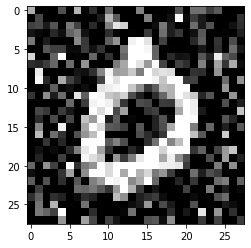

In [6]:
# Plot images - 0
plt.imshow(X[0].T, cmap='gray')

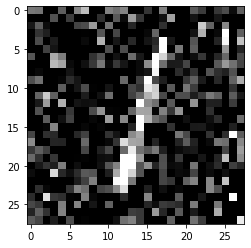

In [7]:
# Plot images - 1
plt.imshow(X[50].T, cmap='gray')

### Part 2
**Implement Alternating least squares algorithm, with tolerance = 1e-04 and max iterations = 50, to decompose each 28 x 28 image in the training set to a 20 x 20 matrix using MATLAB's tucker_als or R's tucker function in rTensor module. Then use either MATLAB's TreeBagger or R's randomForest function to fit a random forest classifier with 500 trees. Please report the classification accuracy of the model for the training set.**  

https://edstem.org/us/courses/25064/discussion/1795939?comment=4180055

In [8]:
max_iter = 50
tol = 1e-04

# Tucker Decomposition
core, factors = tucker(X, rank=[100, 20, 20], n_iter_max=max_iter, tol=tol)
   
# Reconstructing X using G and Ui             
G = tl.tenalg.mode_dot(X, factors[0], mode=0)
X_train = tl.tenalg.multi_mode_dot(G, [factors[1].T, factors[2].T], [1,2])
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])                        

In [9]:
# Train random forest classifier
clf_rf = RandomForestClassifier(n_estimators=500)
clf_rf.fit(X_train_2d,y)
clf_acc = clf_rf.score(X_train_2d, y)

print("Classification Accuracy of X = " + str(round(clf_acc*100)) + '%')

Classification Accuracy of X = 100%


### Part 3
**Using the previously built model, predict the classes of the test and noisy data sets and report the classification accuracy of the model for both datasets. What conclusions can be drawn from your findings and what can be done to further improve the model's response?**

In [10]:
# Reconstructing X using G and Ui
G_test = tl.tenalg.multi_mode_dot(X_test, [factors[1].T, factors[2].T], [1,2])
G_test_2d = G_test.reshape(G_test.shape[0], G_test.shape[1]*G_test.shape[2])

G_noisy = tl.tenalg.multi_mode_dot(X_noisy, [factors[1].T, factors[2].T], [1,2])
G_noisy_2d = G_noisy.reshape(G_noisy.shape[0], G_noisy.shape[1]*G_noisy.shape[2])

In [11]:
clf_acc_test = clf_rf.score(G_test_2d, y_test)
clf_acc_noisy = clf_rf.score(G_noisy_2d, y_noisy)

In [12]:
print("Classification Accuracy of X_test = " + str(round(clf_acc_test*100)) + '%')
print("Classification Accuracy of X_noisy = " + str(round(clf_acc_noisy*100)) + '%')
print("Based on these results, I think the model is overfit; I would expect a lower accuracy from X_noisy but it looks like the model performs the same on X_test and X_noisy. To improve model response, I would test different tensor ranks to see which gives me better test results (ie - 14 instead of 20).")

Classification Accuracy of X_test = 35%
Classification Accuracy of X_noisy = 35%
Based on these results, I think the model is overfit; I would expect a lower accuracy from X_noisy but it looks like the model performs the same on X_test and X_noisy. To improve model response, I would test different tensor ranks to see which gives me better test results (ie - 14 instead of 20).
